# Extract velocity along a boundary (line segment) in a certain direction

In [14]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas.filter2d import dff2d
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves
from iwatlas import uvdriver
from iwatlas import sshdriver
import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams

rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'


In [23]:
# Input variables

dx = 0.02

time = np.datetime64('2012-04-01 00:00:00')

# Northern Boundary
xline = np.arange(113.9,116.6+dx,dx)
yline = -18.5*np.ones_like(xline)
thetalow = 270-60.
thetahigh = 270+60
outfile = '../DATA/Pilbara_MITGCM_NorthBC_uv.nc'


# Eastern boundary
# yline = np.arange(-20.5, -18.5+dx,dx)
# xline = 113.9*np.ones_like(yline)
# thetalow = 360-60.
# thetahigh = 360+60
# outfile = '../DATA/Pilbara_MITGCM_EastBC_uv.nc'

xlims = (xline.min()-1.5, xline.max()+1.5)
ylims = (yline.min()-1.5, yline.max()+1.5)




basedir = '../DATA'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)



In [24]:
u_re_f, u_im_f, v_re_f, v_im_f, X, Y, omega = uvdriver.extract_uv_dff(atlasfile, xlims, ylims, dx, thetalow, thetahigh)

In [25]:
# # East boundary needs to be done in two halves (not great)
# u_re_f1, u_im_f1, v_re_f1, v_im_f1, X, Y, omega = extract_uv_dff(atlasfile, xlims, ylims, dx, 360-60, 0)
# u_re_f2, u_im_f2, v_re_f2, v_im_f2, X, Y, omega = extract_uv_dff(atlasfile, xlims, ylims, dx, 0, 60)

# u_re_f = u_re_f1+u_re_f2
# u_im_f = u_im_f1+u_im_f2
# v_re_f = v_re_f1+v_re_f2
# v_im_f = v_im_f1+v_im_f2

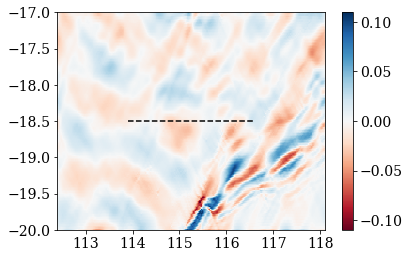

In [26]:
plt.figure()
plt.pcolormesh(X, Y, u_im_f[3,...], cmap='RdBu')
plt.plot(xline, yline,'k--')
plt.colorbar()

In [27]:
U_re, U_im, V_re, V_im, omega = uvdriver.extract_uv_dff_bc(atlasfile, xline, yline, thetalow, thetahigh)

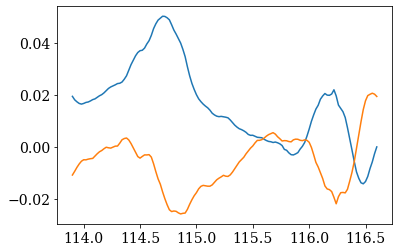

In [32]:
plt.figure()
plt.plot(xline,V_re[3,:])
plt.plot(xline,V_im[3,:])

In [29]:
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nannual: 4, Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 7, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nannual, Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    dz          (Nk) float64 ...
    z_r         (Nk) float64 ...
    N2_mu       (Nparams, Nc) float64 ...
    N2_re       (Nannual

In [30]:
# Export the data to an xarray object
u_re_ds = xr.DataArray(U_re, dims=('Ntide','Nc'))
u_im_ds = xr.DataArray(U_im, dims=('Ntide','Nc'))
v_re_ds = xr.DataArray(V_re, dims=('Ntide','Nc'))
v_im_ds = xr.DataArray(V_im, dims=('Ntide','Nc'))
omega_ds = xr.DataArray(omega, dims=('Ntide',))
x_ds = xr.DataArray(xline, dims=('Nc',))
y_ds = xr.DataArray(yline, dims=('Nc',))

ds = xr.Dataset({'u_re':u_re_ds, 'v_re':v_re_ds, 'u_im':u_im_ds, 'v_im':v_im_ds,
                'omega':omega_ds,'x':x_ds, 'y':y_ds})
ds.attrs = {
            'Description':'Directionally-filtered harmonic velocity amplitude',
            'Atlas_File':atlasfile,
            'Author':'Matt Rayson (matt.rayson@uwa.edu.au)',
            'Created':str(datetime.now()),
            'ReferenceDate':ssh._ds.attrs['ReferenceDate'],
           'DFF_cutoff_low':thetalow,
           'DFF_cutoff_high':thetahigh}

ds.to_netcdf(outfile)
print(outfile)
ds

../DATA/Pilbara_MITGCM_NorthBC_uv.nc


<xarray.Dataset>
Dimensions:  (Nc: 136, Ntide: 35)
Dimensions without coordinates: Nc, Ntide
Data variables:
    u_re     (Ntide, Nc) float64 0.001473 0.001328 ... -0.001681 -0.001428
    v_re     (Ntide, Nc) float64 -0.0001639 0.0001206 ... 0.001317 -0.0001949
    u_im     (Ntide, Nc) float64 0.001108 0.0007174 ... -0.001726 -0.0001791
    v_im     (Ntide, Nc) float64 0.001108 0.0007174 ... -0.001726 -0.0001791
    omega    (Ntide) float64 0.0001399 0.0001401 0.0001403 ... 6.8e-05 6.82e-05
    x        (Nc) float64 113.9 113.9 113.9 114.0 ... 116.5 116.6 116.6 116.6
    y        (Nc) float64 -18.5 -18.5 -18.5 -18.5 ... -18.5 -18.5 -18.5 -18.5
Attributes:
    Description:      Directionally-filtered harmonic velocity amplitude
    Atlas_File:       ../DATA/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc
    Author:           Matt Rayson (matt.rayson@uwa.edu.au)
    Created:          2020-11-27 13:28:22.996475
    ReferenceDate:    1990-01-01T00:00:00
    DFF_cutoff_low:   210.0
    DFF_cutoff_high:  330